In [1]:
import pandas as pd
import utils
import plotly.express as px

### Calculating mean Average Precision (mAP) for CellProfiler features
In this notebook, we calculate the mAP for perturbation detection and perturbation matching tasks for the CellProfiler features.

All compound, ORF and CRISPR plates from the `2020_11_04_CPJUMP1` batch are read, except for those with cell seeding density other than 1000 (100%) and compound plates with antibiotics (Puromycin/Blasticidin) added. Additional annotations for the compounds are also read.

In [2]:
replicability_map_df = pd.DataFrame()
replicability_mmap_df = pd.DataFrame()
matching_map_df = pd.DataFrame()
matching_mmap_df = pd.DataFrame()
gene_compound_matching_map_df = pd.DataFrame()
gene_compound_matching_mmap_df = pd.DataFrame()

feature_to_group_by = "Metadata_broad_sample"
batch = "2020_11_04_CPJUMP1"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

Normalized, feature selected compound profiles for replicate plates at the same time point, using the same cell type are merged into a single data frame. Empty wells are removed before calculating mAP for perturbation detection (retrieve replicates of the query compound). mAP for the random baseline (number of positive matches/total number items in the ranked list of matches) is subtracted.

For the perturbation matching task, compounds that not are replicable (mAP <= 0) are removed. Negative control wells are also removed and the additional target annotations are added before mAP for perturbation matching is calculated. Again, the mAP for the random baseline is subtracted.

Similarly, mAP for perturbation detection is computed for both CRISPR and ORF plates while mAP for perturbation matching is computed only for the CRISPR guides.

Then, mAP for the chemical perturbation-genetic perturbation matching task is computed using the median consensus profiles and the baseline mAP is subtracted.

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query('Cell_type==@cell')
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query('Perturbation==@modality_1_perturbation')
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query('Time==@modality_1_timepoint')
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            # Read all the plates
            data_df = (
                utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                .assign(Metadata_modality=modality_1_perturbation)
            )
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        # Set Metadata_broad_sample value to "DMSO" for DMSO wells
        modality_1_df[feature_to_group_by].fillna("DMSO", inplace=True)

        # Remove empty wells
        modality_1_df = utils.remove_empty_wells(modality_1_df)

        # Description
        description = f'{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}'

        # Calculate replicability mAP
        print(f'Computing {description} replicability')
        precision = utils.PrecisionScores(modality_1_df, modality_1_df, feature_to_group_by, "replicability", "Metadata_broad_sample", within=True, against_negcon=True)

        replicability_map_df, replicability_mmap_df = utils.create_replicability_df(replicability_map_df, replicability_mmap_df, precision, modality_1_perturbation, cell, modality_1_timepoint)

        # Remove DMSO wells
        modality_1_df = utils.remove_negcon_empty_wells(modality_1_df)

        # Create consensus profiles
        modality_1_consensus_df = utils.consensus(modality_1_df, feature_to_group_by)

        # Filter out non-replicable compounds
        replicable_compounds = list(replicability_map_df[(replicability_map_df.Description==description) & (replicability_map_df.mAP>0)][feature_to_group_by])
        modality_1_consensus_df = modality_1_consensus_df.query('Metadata_broad_sample==@replicable_compounds').reset_index(drop=True)

        # Adding additional gene annotation metadata
        modality_1_consensus_df = (
            modality_1_consensus_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
        )

        # Expand compound profiles and add new matching_target column
        modality_1_consensus_expanded_df = (
            modality_1_consensus_df.assign(Metadata_matching_target= lambda x: x.Metadata_target_list.str.split('|'))
            .explode('Metadata_matching_target')
            .reset_index(drop=True)
        )
        modality_1_consensus_df = modality_1_consensus_df.assign(Metadata_matching_target=lambda x: x.Metadata_target_list)

        # Calculate compound-compound matching
        print(f'Computing {description} matching')
        precision = utils.PrecisionScores(modality_1_consensus_expanded_df, modality_1_consensus_df, "Metadata_matching_target", "matching", "Metadata_broad_sample", within=True, anti_correlation=True)

        matching_map_df, matching_mmap_df = utils.create_matching_df(matching_map_df, matching_mmap_df, precision, modality_1_perturbation, cell, modality_1_timepoint)

        all_modality_2_experiments_df = cell_df.query('Perturbation!=@modality_1_perturbation')
        for modality_2_perturbation in all_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = all_modality_2_experiments_df.query('Perturbation==@modality_2_perturbation')
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query('Time==@modality_2_timepoint')

                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_matching_target=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_2_df, data_df)

                # Remove empty wells
                modality_2_df = utils.remove_empty_wells(modality_2_df)

                # Description
                description = f'{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}'

                # Calculate replicability mAP

                if not replicability_map_df.Description.str.contains(description).any():
                    print(f'Computing {description} replicability')
                    precision = utils.PrecisionScores(modality_2_df, modality_2_df, feature_to_group_by,"replicability", "Metadata_broad_sample", within=True, against_negcon=True)

                    replicability_map_df, replicability_mmap_df = utils.create_replicability_df(replicability_map_df, replicability_mmap_df, precision, modality_2_perturbation, cell, modality_2_timepoint)

                # Remove negcon wells
                modality_2_df = utils.remove_negcon_empty_wells(modality_2_df)

                # Create consensus profiles
                modality_2_consensus_df = utils.consensus(modality_2_df, "Metadata_broad_sample")

                # Filter out non-replicable genes
                replicable_genes = list(replicability_map_df[(replicability_map_df.Description==f'{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}') & (replicability_map_df.mAP>0)][feature_to_group_by])
                modality_2_consensus_df = modality_2_consensus_df.query('Metadata_broad_sample==@replicable_genes').reset_index(drop=True)

                # Calculate cripsr-crispr matching
                if modality_2_perturbation == "crispr":
                    if not matching_map_df.Description.str.contains(description).any():
                        print(f'Computing {description} matching')
                        precision = utils.PrecisionScores(modality_2_consensus_df, modality_2_consensus_df, "Metadata_gene", "matching", "Metadata_broad_sample", within=True)

                        matching_map_df, matching_mmap_df = utils.create_matching_df(matching_map_df, matching_mmap_df, precision, modality_2_perturbation, cell, modality_2_timepoint)

                # Filter out genes that are not perturbed by ORFs or CRISPRs
                perturbed_genes = list(set(modality_2_consensus_df.Metadata_matching_target))
                modality_1_consensus_expanded_filtered_df = modality_1_consensus_expanded_df.query('Metadata_matching_target==@perturbed_genes').reset_index(drop=True)
                
                # Calculate gene-compound matching mAP
                description = f'{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}-{modality_2_perturbation}_{cell}_{utils.time_point(modality_2_perturbation, modality_2_timepoint)}'
                print(f'Computing {description} matching')
                precision = utils.PrecisionScores(modality_1_consensus_expanded_filtered_df, modality_2_consensus_df, "Metadata_matching_target", "matching", "Metadata_broad_sample", anti_correlation=True)

                gene_compound_matching_map_df, gene_compound_matching_mmap_df = utils.create_gene_compound_matching_df(gene_compound_matching_map_df, gene_compound_matching_mmap_df, precision, modality_1_perturbation, modality_2_perturbation, cell, modality_1_timepoint, modality_2_timepoint)


Computing compound_A549_short replicability
Computing compound_A549_short matching
Computing crispr_A549_long replicability
Computing crispr_A549_long matching
Computing compound_A549_short-crispr_A549_long matching
Computing crispr_A549_short replicability
Computing crispr_A549_short matching
Computing compound_A549_short-crispr_A549_short matching
Computing orf_A549_long replicability
Computing compound_A549_short-orf_A549_long matching
Computing orf_A549_short replicability
Computing compound_A549_short-orf_A549_short matching
Computing compound_A549_long replicability
Computing compound_A549_long matching
Computing compound_A549_long-crispr_A549_long matching
Computing compound_A549_long-crispr_A549_short matching
Computing compound_A549_long-orf_A549_long matching
Computing compound_A549_long-orf_A549_short matching
Computing compound_U2OS_short replicability
Computing compound_U2OS_short matching
Computing crispr_U2OS_long replicability
Computing crispr_U2OS_long matching
Computi

Tables of mAP values and the summarized mean mAP (mmAP) are printed and bar plots are plotted.

Replicability mmAP

In [4]:
print(replicability_mmap_df[['Description', 'timepoint', 'mmAP']].to_markdown(index=False))

| Description         |   timepoint |   mmAP |
|:--------------------|------------:|-------:|
| compound_A549_short |          24 |  0.532 |
| crispr_A549_long    |         144 |  0.394 |
| crispr_A549_short   |          96 |  0.373 |
| orf_A549_long       |          96 |  0.148 |
| orf_A549_short      |          48 |  0.16  |
| compound_A549_long  |          48 |  0.703 |
| compound_U2OS_short |          24 |  0.55  |
| crispr_U2OS_long    |         144 |  0.255 |
| crispr_U2OS_short   |          96 |  0.334 |
| orf_U2OS_short      |          48 |  0.318 |
| orf_U2OS_long       |          96 |  0.214 |
| compound_U2OS_long  |          48 |  0.496 |


Within perturbation matching mmAP

In [5]:
print(matching_mmap_df[['Description', 'timepoint', 'mmAP']].to_markdown(index=False))

| Description         |   timepoint |   mmAP |
|:--------------------|------------:|-------:|
| compound_A549_short |          24 |  0.108 |
| crispr_A549_long    |         144 |  0.088 |
| crispr_A549_short   |          96 |  0.062 |
| compound_A549_long  |          48 |  0.12  |
| compound_U2OS_short |          24 |  0.078 |
| crispr_U2OS_long    |         144 |  0.076 |
| crispr_U2OS_short   |          96 |  0.067 |
| compound_U2OS_long  |          48 |  0.11  |


Gene-compound matching mmAP

In [6]:
print(gene_compound_matching_mmap_df[['Description', 'Cell', 'mmAP']].to_markdown(index=False))

| Description                           | Cell   |   mmAP |
|:--------------------------------------|:-------|-------:|
| compound_A549_short-crispr_A549_long  | A549   |  0.027 |
| compound_A549_short-crispr_A549_short | A549   |  0.026 |
| compound_A549_short-orf_A549_long     | A549   |  0.032 |
| compound_A549_short-orf_A549_short    | A549   |  0.037 |
| compound_A549_long-crispr_A549_long   | A549   |  0.032 |
| compound_A549_long-crispr_A549_short  | A549   |  0.032 |
| compound_A549_long-orf_A549_long      | A549   |  0.03  |
| compound_A549_long-orf_A549_short     | A549   |  0.032 |
| compound_U2OS_short-crispr_U2OS_long  | U2OS   |  0.032 |
| compound_U2OS_short-crispr_U2OS_short | U2OS   |  0.028 |
| compound_U2OS_short-orf_U2OS_short    | U2OS   |  0.039 |
| compound_U2OS_short-orf_U2OS_long     | U2OS   |  0.045 |
| compound_U2OS_long-crispr_U2OS_long   | U2OS   |  0.033 |
| compound_U2OS_long-crispr_U2OS_short  | U2OS   |  0.024 |
| compound_U2OS_long-orf_U2OS_short     

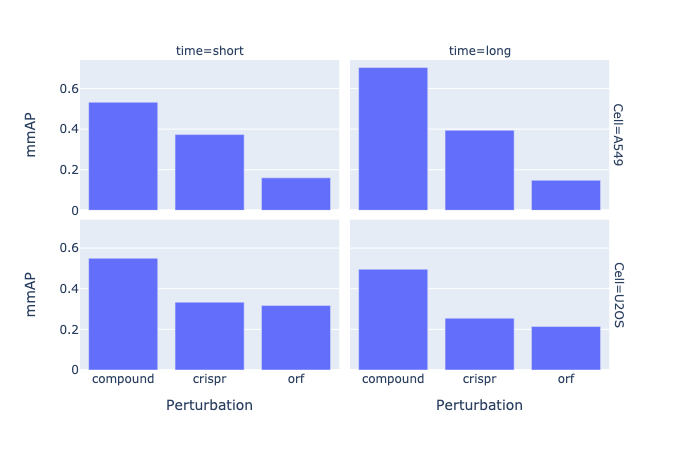

In [7]:
fig = px.bar(data_frame=replicability_mmap_df,
             x='Modality',
             y='mmAP',
             facet_row='Cell',
             facet_col='time')
fig.update_layout(xaxis1=dict(title='Perturbation'),
                  xaxis2=dict(title='Perturbation'),
                  yaxis1=dict(title='mmAP'),
                  yaxis3=dict(title='mmAP'))
fig.show("png")
fig.write_image(f'figures/1.CellProfiler_replicability_mmap.png', width=640, height=480, scale=2)

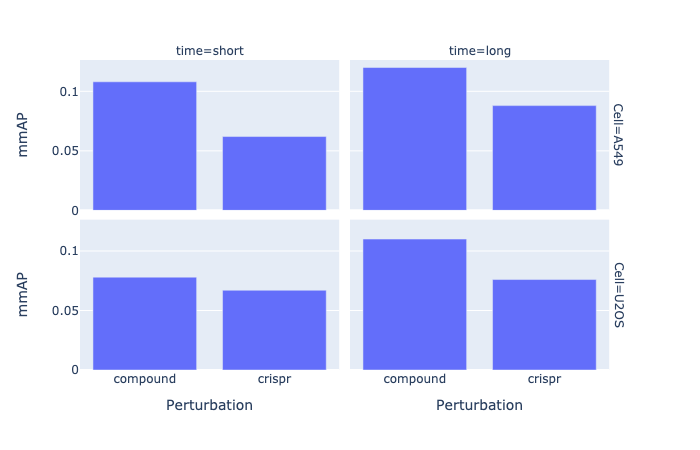

In [8]:
fig = px.bar(data_frame=matching_mmap_df,
             x='Modality',
             y='mmAP',
             facet_row='Cell',
             facet_col='time')
fig.update_layout(xaxis1=dict(title='Perturbation'),
                  xaxis2=dict(title='Perturbation'),
                  yaxis1=dict(title='mmAP'),
                  yaxis3=dict(title='mmAP'))
fig.show("png")
fig.write_image(f'figures/1.CellProfiler_matching_mmap.png', width=640, height=480, scale=2)

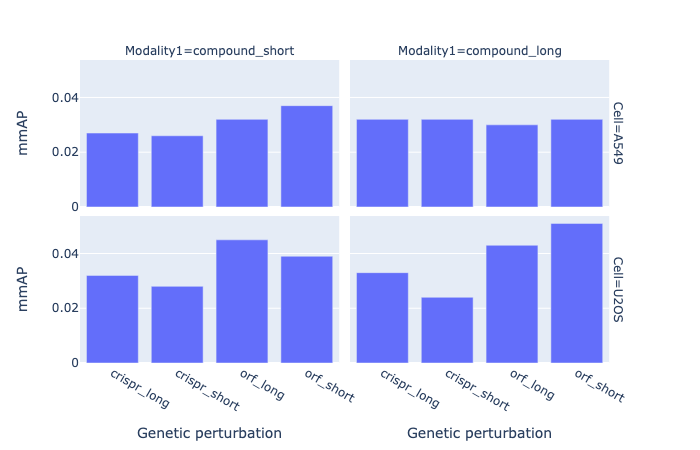

In [9]:
fig = px.bar(gene_compound_matching_mmap_df,
             x='Modality2',
             y='mmAP',
             facet_col='Modality1',
             facet_row='Cell')
fig.update_layout(xaxis1=dict(title='Genetic perturbation'),
                  xaxis2=dict(title='Genetic perturbation'),
                  yaxis1=dict(title='mmAP'),
                  yaxis3=dict(title='mmAP'))
fig.show("png")
fig.write_image(f'figures/1.CellProfiler_gene_compound_matching_mmap.png', width=640, height=480, scale=2)

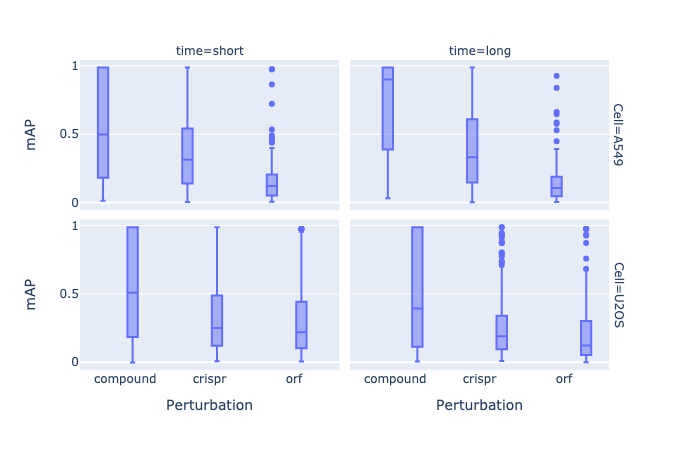

In [10]:
fig = px.box(data_frame=replicability_map_df,
                x='Modality',
                y='mAP',
                facet_row='Cell',
                facet_col='time')
fig.update_layout(xaxis1=dict(title='Perturbation'),
                  xaxis2=dict(title='Perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/1.CellProfiler_replicability_map.png', width=640, height=480, scale=2)

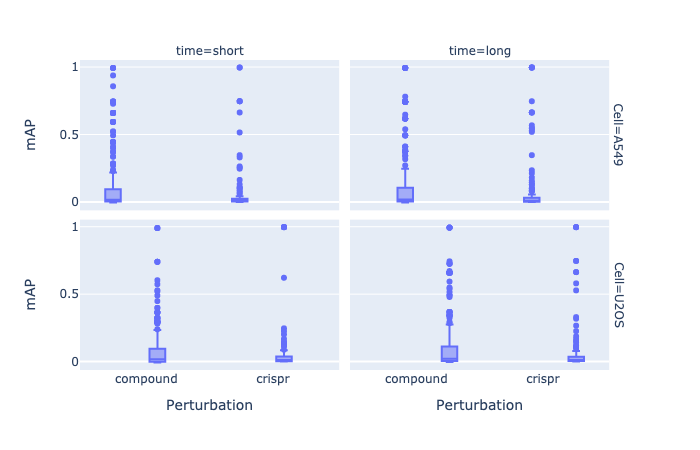

In [11]:
fig = px.box(data_frame=matching_map_df,
                x='Modality',
                y='mAP',
                facet_row='Cell',
                facet_col='time')
fig.update_layout(xaxis1=dict(title='Perturbation'),
                  xaxis2=dict(title='Perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/1.CellProfiler_matching_map.png', width=640, height=480, scale=2)

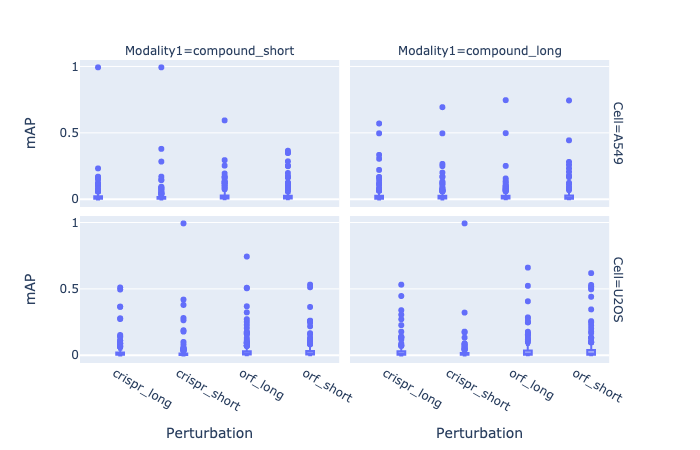

In [12]:
fig = px.box(data_frame=gene_compound_matching_map_df,
             x='Modality2',
             y='mAP',
             facet_col='Modality1',
             facet_row='Cell')
fig.update_layout(xaxis1=dict(title='Perturbation'),
                  xaxis2=dict(title='Perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/1.CellProfiler_gene_compound_matching_map.png', width=640, height=480, scale=2)

Tables of mAP and mmAP values are written to file.

In [13]:
replicability_mmap_df[['Modality','Cell','time','mmAP']].to_csv('output/cellprofiler_replicability_mmap.csv', index=False)
replicability_map_df[['Modality','Cell','time','mAP']].to_csv('output/cellprofiler_replicability_map.csv', index=False)
matching_mmap_df[['Modality', 'Cell', 'time', 'mmAP']].to_csv('output/cellprofiler_matching_mmap.csv', index=False)
matching_map_df[['Modality', 'Cell', 'time', 'mAP']].to_csv('output/cellprofiler_matching_map.csv', index=False)
gene_compound_matching_mmap_df[['Modality1', 'Modality2', 'Cell', 'mmAP']].to_csv('output/cellprofiler_gene_compound_matching_mmap.csv', index=False)
gene_compound_matching_map_df[['Modality1', 'Modality2', 'Cell', 'mAP']].to_csv('output/cellprofiler_gene_compound_matching_map.csv', index=False)